###  About
####  Generate response for the question from pre-defined text using LLM(Extracted Question-Answering(QA) Model).

### Import Necessary Libraries & Packages

In [1]:
pip install pyspellchecker==0.5.6 -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
stopwords=set(STOPWORDS)
import re
import random
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline
import warnings
#import contractions
import unidecode
from collections import Counter
import spacy
from nltk.stem import PorterStemmer
porter = PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
warnings.filterwarnings('ignore')
from collections import defaultdict
from tqdm.notebook import tqdm_notebook
from spellchecker import SpellChecker

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load train and test dataset

In [4]:
train=pd.read_csv("/kaggle/input/mh-intel-oneapi-hackathon-the-llm-challenge/train.csv")
test=pd.read_csv("/kaggle/input/mh-intel-oneapi-hackathon-the-llm-challenge/test.csv")

### Let's see the structure of train and test dataset

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66611 entries, 0 to 66610
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Story       66611 non-null  object 
 1   Question    66611 non-null  object 
 2   span_start  58286 non-null  float64
 3   span_end    58035 non-null  float64
 4   span_text   58236 non-null  object 
 5   Answer      66611 non-null  object 
dtypes: float64(2), object(4)
memory usage: 3.0+ MB


#### The train dataset contains 666111 data entries and 5 columns.
#### Story column contains the document to extract the answer based on the question.
#### The Question column contains questions related to the document.
#### Span_start and span_end contains the character offset position of an answer.
#### Span_text columns contains the tokens(characters/words) based on the span_start and span_end position.
#### Answer contains the answer related to the question.The answer is extracted from the document by using LLM.

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28548 entries, 0 to 28547
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Story     28548 non-null  object
 1   Question  28548 non-null  object
dtypes: object(2)
memory usage: 446.2+ KB


#### The test dataset contains 28548 entries and 2 columns.

### Let's check if there is any missing value in train and test dataset.

In [7]:
train.isnull().sum()

Story            0
Question         0
span_start    8325
span_end      8576
span_text     8375
Answer           0
dtype: int64

In [8]:
test.isnull().sum()

Story       0
Question    0
dtype: int64

### Let's view the sample data from train and test dataset

In [9]:
train.head(3)

,Story,Question,span_start,span_end,span_text,Answer
0,CHAPTER IV. \n\nNotwithstanding the earnest in...,What emotions did she show?,199.0,288.0,The countenance of this young lady exhibited a...,mirth and sadness
1,"(CNN) -- Polk County, Florida, detectives arre...",What do police believe the motive to be?,428.0,465.0,We believe that his motive is robbery,robbery
2,"Malawi (, or ; or [maláwi]), officially the Re...",Is it a large country?,653.0,702.0,Malawi is among the smallest countries in Africa.,No


### Let's explore the answers.
#### The answer column contains some invalid answers.let's see how many answers are invalid.

In [10]:
train['Answer'].str.match("(Unknown.?)").value_counts()

Answer
False    66603
True         8
Name: count, dtype: int64

In [11]:
train[train['Answer'].str.match("(Unknown.?)")][['span_text','Question','Answer']]

,span_text,Question,Answer
6924,They knew many of the young men and women,"How many others, exactly?",Unknown.
9332,"Time passed on, and Edmund Burgess, who had be...",Who sent him to hone his craft?,Unknown
11038,The 45-year-old poured gasoline over his body ...,Was he able to run around while burning?,Unknown
11137,Senate Armed Services Committee's subcommittee...,Why was she testifying?,Unknown
22374,But I don't hate you,Does Helen like Sadie?,Unknown.
30835,What they talked about none of the others knew...,What did they speak of?,Unknown.
50944,a few yards of cotton cloth,Of what color?,Unknown.
60284,They had been down to Cedarville to purchase s...,Did they buy something for Tom?,Unknown.


#### There are 8 invalid answers in the dataset.

### Let's see the answer's character length distribution

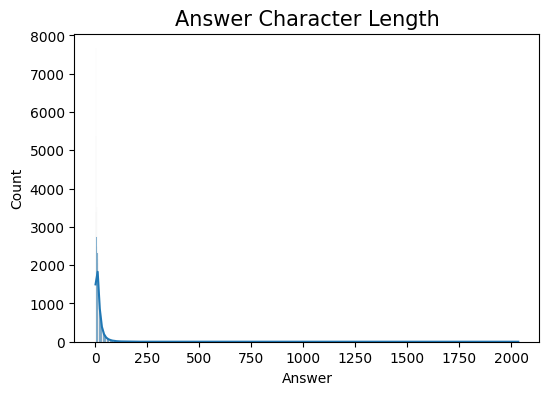

In [12]:
_=plt.figure(figsize=(6, 4))
_=sns.histplot(train['Answer'].str.len(),kde=True)
_=plt.title( 'Answer Character Length',fontsize=15)

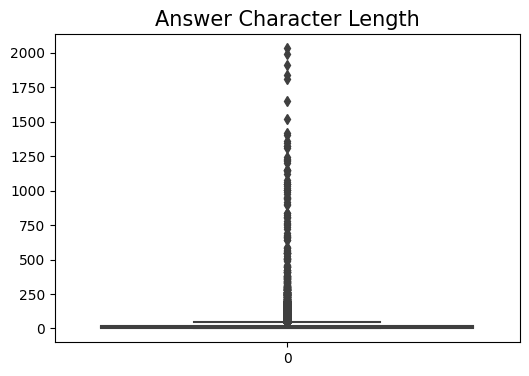

In [13]:
_=plt.figure(figsize=(6, 4))
_=sns.boxplot(train['Answer'].str.len())
_=plt.title( 'Answer Character Length',fontsize=15)

In [14]:
train['Answer'].str.len().describe()

count    66611.000000
mean        18.449250
std         42.566958
min          1.000000
25%          5.000000
50%         11.000000
75%         21.000000
max       2033.000000
Name: Answer, dtype: float64

#### The average character length of an answer is 18.
#### The answer's character length ranges from 1 to 2033.
#### The maximum length of an answer is 2033. Let's explore that answer.

In [15]:
train[train['Answer'].str.len()==2033]

,Story,Question,span_start,span_end,span_text,Answer
23205,(CNN) -- Only two Republican presidential cand...,What is the purpose of the corrupt kabuki in t...,17.0,417.0,[SEP] ( cnn ) - - only two republican presiden...,[SEP] ( cnn ) - - only two republican presiden...


#### The above answer same as story the only difference is special tokens(SEP, CLS) are added.


### Let's see if there are any answers that are exactly the same as the story and include special tokens.

In [16]:
train[train['Answer'].str.contains("\[SEP\]")==True]

,Story,Question,span_start,span_end,span_text,Answer
178,(CNN) -- The threatening calls reportedly came...,What happened after two extortionists were arr...,0.0,12.0,[CLS] what happened after two extortionists we...,[CLS] what happened after two extortionists we...
383,(CNN) -- Americans snicker over the sordid det...,What role do Americans believe the wronged pol...,0.0,239.0,[CLS] what role do americans believe the wrong...,[CLS] what role do americans believe the wrong...
1059,"CHAPTER XVI \n\nMORE DISCOVERIES \n\n""You sett...",What documents did Anderson Rover say he did n...,0.0,109.0,[CLS] what documents did anderson rover say he...,[CLS] what documents did anderson rover say he...
1868,(CNN) -- North Korea twice came back from behi...,How did North Korea manage to come back from b...,0.0,15.0,[CLS] how did north korea manage to come back ...,[CLS] how did north korea manage to come back ...
3136,(CNN) -- Maria Sharapova was forced to call on...,What caused Garbine Muguruza to play with such...,0.0,272.0,[CLS] what caused garbine muguruza to play wit...,[CLS] what caused garbine muguruza to play wit...
...,...,...,...,...,...,...
63757,Chapter 14 \n\nTHROUGH THE VALLEY \n\nSampson ...,What was Sampson asking Wright to do as a favor?,0.0,12.0,[CLS] what was sampson asking wright to do as ...,[CLS] what was sampson asking wright to do as ...
64962,"Eminem got sober, Arcade Fire got spooked, Kat...",What did Katy Perry flash in her hits?,10.0,10.0,[SEP],[SEP]
65366,CHAPTER XVIII. \n\n\n\nIt was a beautiful July...,What is the name of the little girl being chri...,0.0,13.0,[CLS] what is the name of the little girl bein...,[CLS] what is the name of the little girl bein...
66304,CHAPTER VI \n\nTHE VANISHING LADY \n\nAt preci...,What type of car did Duncombe arrive in?,0.0,38.0,[CLS] what type of car did duncombe arrive in ...,[CLS] what type of car did duncombe arrive in ...


#### There are 105 answers same as the story with special tokens. These 105 answers are not valid one to feed to the model.

### Let's see answers that has less than 6 characters.

In [17]:
train[train['Answer'].str.len()<6]['Answer'].str.lower()

2           no
9           no
13       seven
21          25
28          no
         ...  
66598      yes
66602      yes
66603      yes
66606     apri
66607     grey
Name: Answer, Length: 19207, dtype: object

In [18]:
def wordcloud(df,col,plot_size=(15,15),title=""):
    fig=plt.subplots(figsize=plot_size)
    wc = WordCloud(background_color="white", max_words=100, stopwords=stopwords,
                max_font_size=40, random_state=42).generate(df[col].to_string())
    plt.imshow(wc)
    plt.title(f"{title}",fontsize=25)
    plt.axis('off')

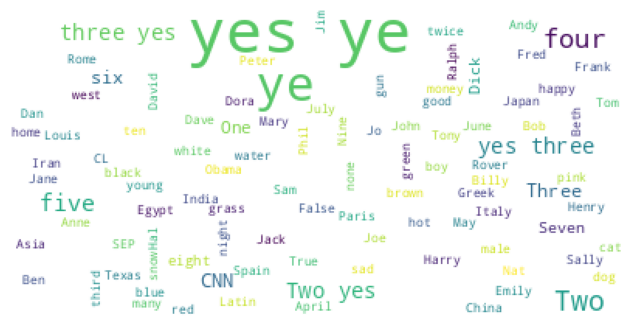

In [19]:
wordcloud(train[train['Answer'].str.len()<6][['Answer']],'Answer',plot_size=(8,6))

### Let's see number of words distribution of answer

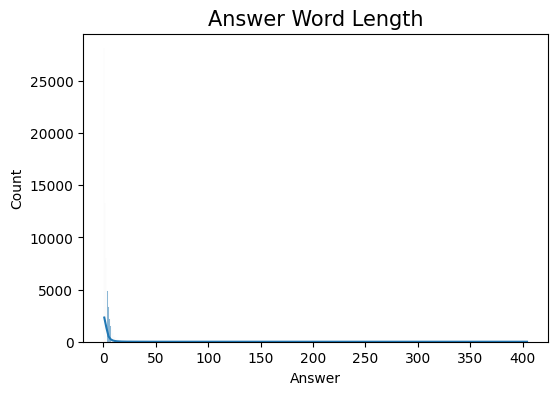

In [20]:
_=plt.figure(figsize=(6, 4))
_=sns.histplot(train['Answer'].apply(lambda x: len(x.split())),kde=True)
_=plt.title( 'Answer Word Length',fontsize=15)

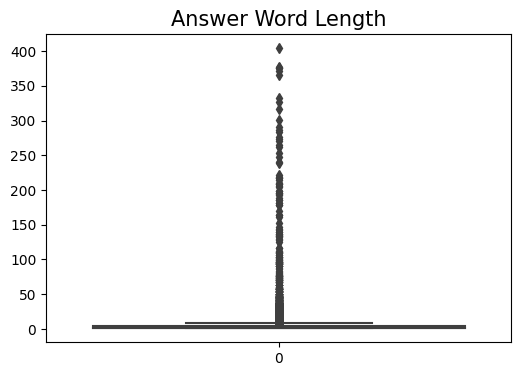

In [21]:
_=plt.figure(figsize=(6, 4))
_=sns.boxplot(train['Answer'].apply(lambda x: len(x.split())))
_=plt.title( 'Answer Word Length',fontsize=15)

In [22]:
train['Answer'].apply(lambda x: len(x.split())).describe()

count    66611.000000
mean         3.408731
std          8.540431
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        404.000000
Name: Answer, dtype: float64

#### The average word length of an answer is 3.5.
#### The answer's word length ranges from 1 to 404.

### Let's see what type of questions are in the question column. 

In [23]:
train['question_type']=train['Question'].str.lower().str.extract("(\w+)")

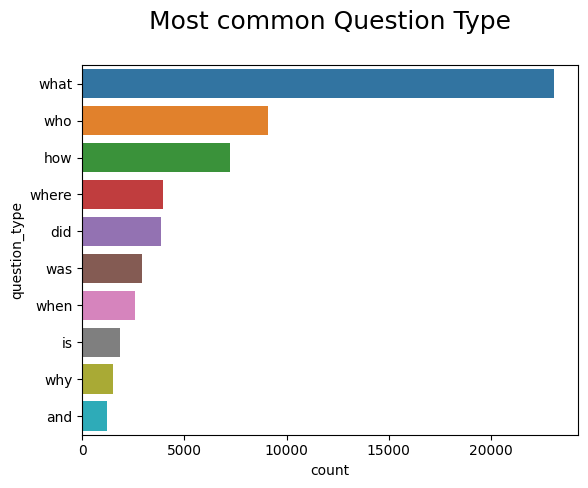

In [24]:
sns.barplot(train.groupby('question_type')['question_type'].agg({'count'}).reset_index().nlargest(10,'count'),
            y='question_type',x='count');
_=plt.title("Most common Question Type\n",fontsize=18)

#### The above plot explains that most question belongs to "wh" type question category.

### Let's see the question's character length distribution

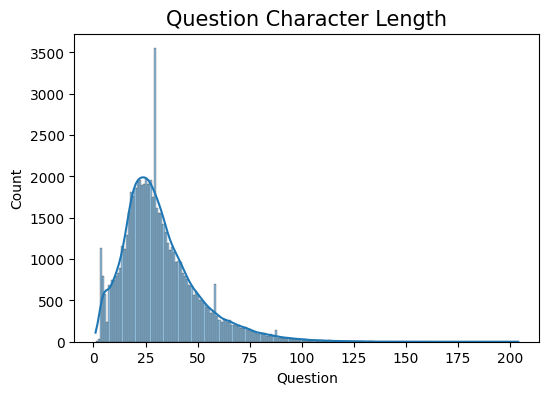

In [25]:
_=plt.figure(figsize=(6, 4))
_=sns.histplot(train['Question'].str.len(),kde=True)
_=plt.title( 'Question Character Length',fontsize=15)

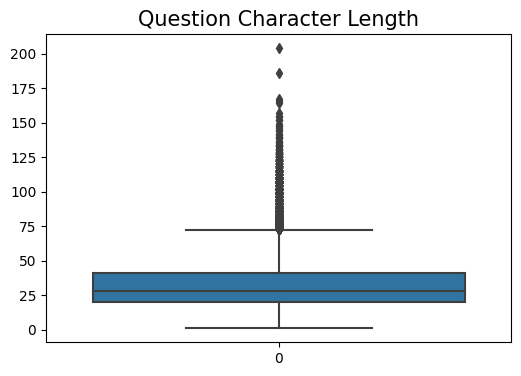

In [26]:
_=plt.figure(figsize=(6, 4))
_=sns.boxplot(train['Question'].str.len())
_=plt.title( 'Question Character Length',fontsize=15)

In [27]:
train['Question'].str.len().describe()

count    66611.000000
mean        32.076729
std         18.384613
min          1.000000
25%         20.000000
50%         28.000000
75%         41.000000
max        204.000000
Name: Question, dtype: float64

#### The average character length of a question is 32.
#### The question's character length ranges from 1 to 204.

### Let's explore single character length question.

In [28]:
train[train['Question'].str.len()==1]['Question']

13140    W
16044    v
18437    v
22623    W
53197    "
60232    ?
Name: Question, dtype: object

#### The above questions are one-character long and have no meaning.

### Let's see the question's word length distribution

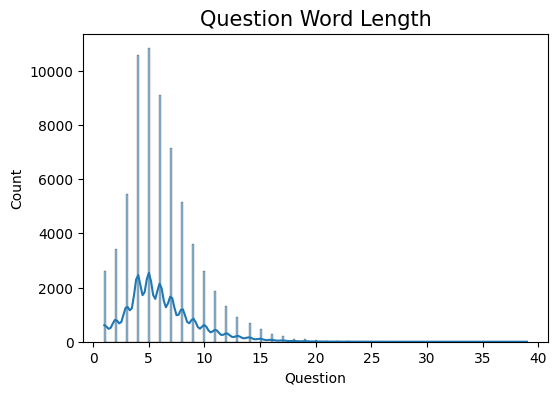

In [29]:
_=plt.figure(figsize=(6, 4))
_=sns.histplot(train['Question'].apply(lambda x: len(x.split())),kde=True)
_=plt.title( 'Question Word Length',fontsize=15)

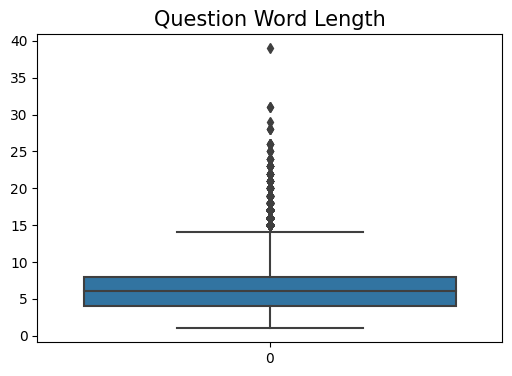

In [30]:
_=plt.figure(figsize=(6, 4))
_=sns.boxplot(train['Question'].apply(lambda x: len(x.split())))
_=plt.title( 'Question Word Length',fontsize=15)

In [31]:
train['Question'].apply(lambda x: len(x.split())).describe()

count    66611.000000
mean         6.100209
std          3.158012
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         39.000000
Name: Question, dtype: float64

#### The average word length of a question is 6.
#### The question's word length ranges from 1 to 39.

### Let's check if there are typos in question_type.

### Initialize spell checker

In [32]:
spell = SpellChecker() 

In [33]:
for wrd in train['question_type'].astype('str'):
    res=spell.unknown([wrd])
    if res:
        print(spell.unknown([wrd]))

{'whp'}
{'compaired'}
{'wherer'}
{'hwere'}
{'sizewise'}
{'ws'}
{'spcifically'}
{'montesquieu'}
{'cwhat'}
{'wasiit'}
{'accorrding'}
{'w'}
{'anad'}
{'wh'}
{'porler'}
{'wjat'}
{'v'}
{'spitsbergen'}
{'v'}
{'ciggerettes'}
{'wsho'}
{'wghat'}
{'btw'}
{'naame'}
{'alnwick'}
{'tipsarevic'}
{'w'}
{'andthing'}
{'afternoon'}
{'unitil'}
{'name1'}
{'transcaucasus'}
{'diod'}
{'cladius'}
{'aret'}
{'lagune'}
{'whaere'}
{'doesthe'}
{'fordyce'}
{'hpw'}
{'baitullah'}
{'sonsored'}
{'goodrun'}
{'whgat'}
{'querr'}
{'wahat'}
{'wgat'}
{'qari'}
{'wjem'}
{'w'}
{'specfically'}
{'betweem'}
{'whhen'}
{'whatpart'}
{'b'}
{'ultratop'}
{'wehre'}
{'aznd'}
{'whgat'}
{'howso'}
{'earg'}
{'nuse'}
{'turkmenistan'}
{'ejsy'}


#### The spell checker identifies a significant number of errors in the 'question_type'.

### Let's explore the relationship between the question and answer character lengths by the most common question types.

In [34]:
train['question_chr_length']=train['Question'].str.len()
train['answer_chr_length']=train['Answer'].str.len()
train['question_word_length']=train['Question'].apply(lambda x: len(x.split()))
train['answer_word_length']=train['Answer'].apply(lambda x: len(x.split()))

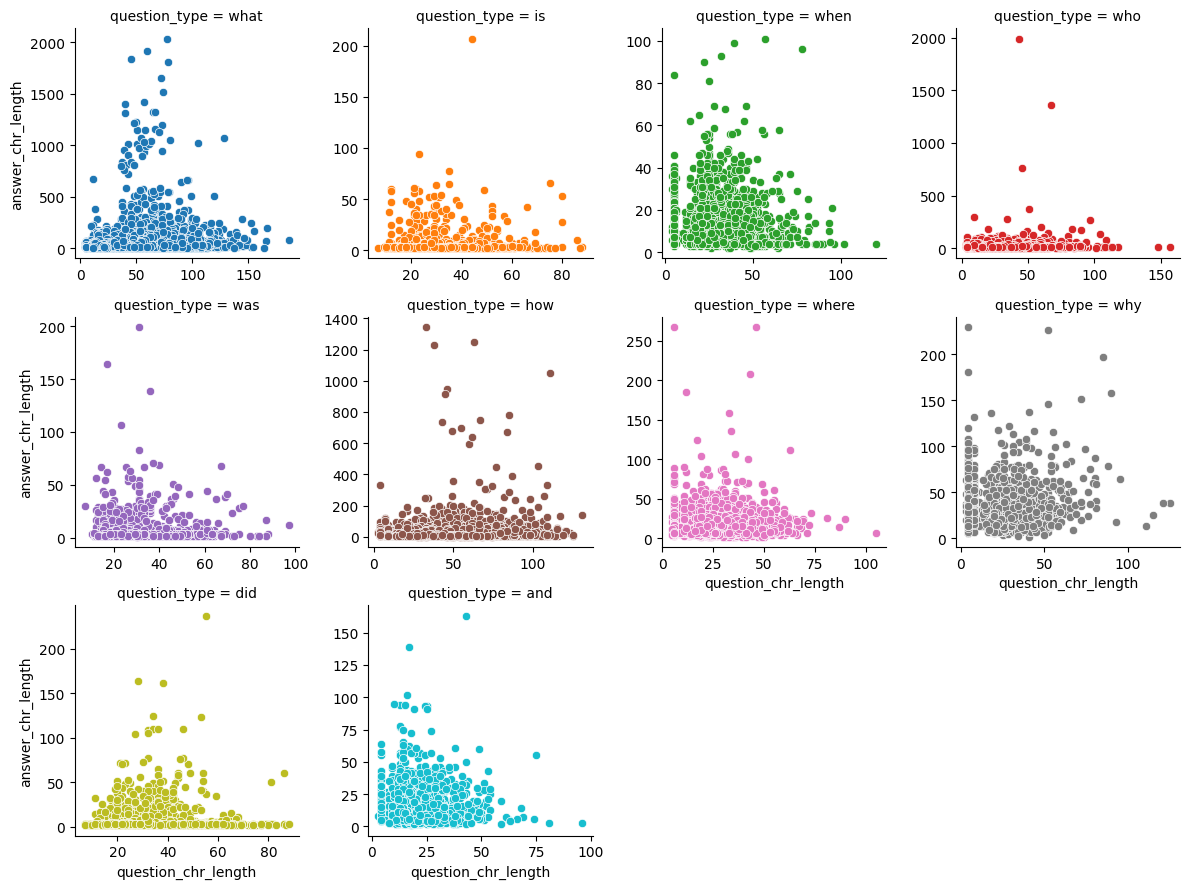

In [35]:
grid=sns.FacetGrid(train[train['question_type'].isin(train.groupby('question_type')['question_type'].agg({'count'}).reset_index().nlargest(10,'count')['question_type'].values)],
           col='question_type',
                     col_wrap=4,hue='question_type',sharex=False,sharey=False);
grid.map(sns.scatterplot,"question_chr_length","answer_chr_length");    

### Let's explore the story column and see character length distribution of story.

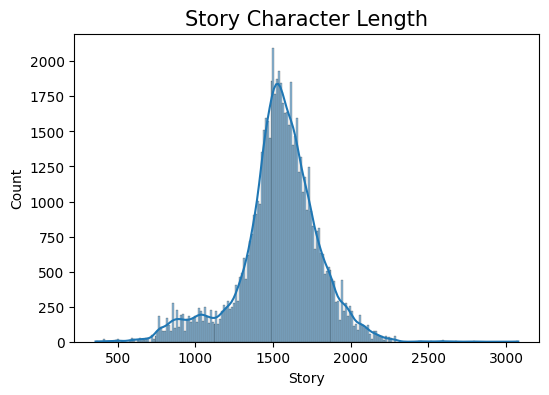

In [36]:
_=plt.figure(figsize=(6, 4))
_=sns.histplot(train['Story'].str.len(),kde=True)
_=plt.title( 'Story Character Length',fontsize=15)

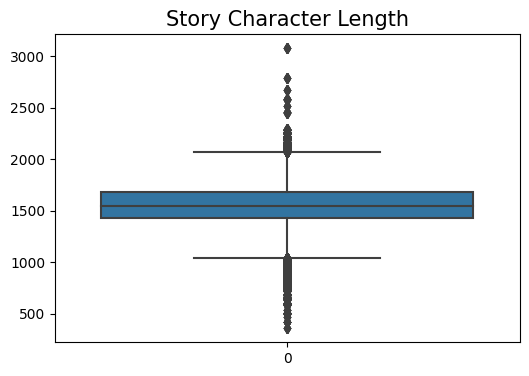

In [37]:
_=plt.figure(figsize=(6, 4))
_=sns.boxplot(train['Story'].str.len())
_=plt.title( 'Story Character Length',fontsize=15)

In [38]:
train['Story'].str.len().describe()

count    66611.000000
mean      1536.237393
std        257.640554
min        358.000000
25%       1428.000000
50%       1550.000000
75%       1684.500000
max       3078.000000
Name: Story, dtype: float64

#### The average character length of a story is 1536.
#### The character length of a story ranges from 358 to 3078.

### Let's explore the story column and see word length distribution of story.

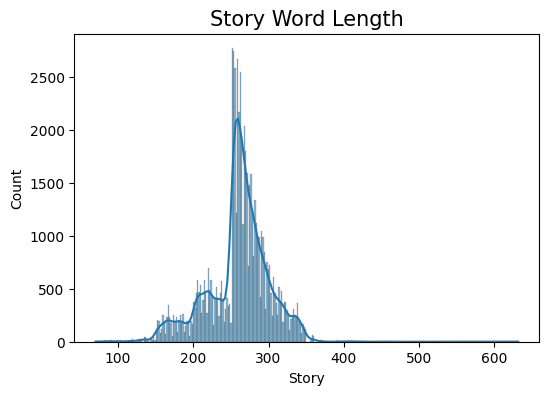

In [39]:
_=plt.figure(figsize=(6, 4))
_=sns.histplot(train['Story'].apply(lambda x: len(x.split())),kde=True)
_=plt.title( 'Story Word Length',fontsize=15)

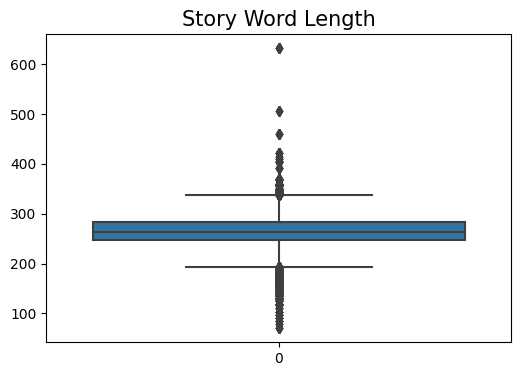

In [40]:
_=plt.figure(figsize=(6, 4))
_=sns.boxplot(train['Story'].apply(lambda x: len(x.split())))
_=plt.title( 'Story Word Length',fontsize=15)

In [41]:
train['Story'].apply(lambda x: len(x.split())).describe()

count    66611.000000
mean       260.242738
std         40.732796
min         70.000000
25%        247.000000
50%        263.000000
75%        283.000000
max        632.000000
Name: Story, dtype: float64

#### The average word length of a story is 260.
#### The word length of a story ranges from 70 to 632.

#### The story column contains 5065 unique content. 

In [42]:
train['Story'].nunique()

5065

#### Let's explore from which story content were the most questions created?

In [43]:
train.groupby(['Story'],as_index=False).agg({'Question':'count'}).sort_values('Question',ascending=False)

,Story,Question
3886,"New York (CNN) -- A self-described ""ex-madam"" ...",139
4753,"The region, as part of Lorraine, was part of t...",87
1062,"Abidjan, Ivory Coast (CNN) -- The European Uni...",80
2664,CHAPTER XXX \n\nFERN Mullins rushed into the h...,72
330,"(CNN) -- Hilary Duff says her new album is ""ve...",70
...,...,...
2293,CHAPTER XVI \n\nTHE RUSE \n\nCliffe and his da...,1
5032,Wolfgang Amadeus Mozart (; ; ; 27 January 1756...,1
4004,One day Mary took a walk to the park. The park...,1
2183,CHAPTER XIX \n\nA GENEROUS OFFER \n\nIt was la...,1


In [44]:
train.groupby(['Story'])['Question'].count().describe()

count    5065.000000
mean       13.151234
std         5.130604
min         1.000000
25%        10.000000
50%        13.000000
75%        16.000000
max       139.000000
Name: Question, dtype: float64

#### The average number of questions created from the story content is 13.
#### Questions were created for the story content, ranging from 1 to 139.

### More number of questions were created from the following story content.

In [45]:
train['Story'][300]

'New York (CNN) -- A self-described "ex-madam" who claims she supplied fellow city comptroller candidate Eliot Spitzer with escorts several years ago is facing charges of illegally distributing prescription drugs, authorities said. \n\nKristin Davis, 38, was arrested on Monday night and charged with selling Adderall, Xanax and other drugs. She\'s also accused of orchestrating the sale of approximately 180 oxycodone pills for cash. \n\nThe candidate was released Tuesday on $100,000 bail, with a preliminary hearing scheduled for September 5. Prosecutors said she will have strict pretrial supervision. \n\n"Prescription drug abuse is the fastest-growing drug problem in this country, resulting in more overdose deaths than heroin and cocaine combined, and this office has a zero tolerance policy towards anyone who helps to spread this plague at any level," Preet Bharara, Manhattan U.S. Attorney, said in a statement. \n\nSpitzer, Weiner and why New York is talking about sex \n\nDavis is charge

### 139 Questions related to the above story content.

In [46]:
" | ".join(i for i in train[train['Story'].str.contains("New York \(CNN\) -- A self")==True]['Question'])

"What information could he provide? | How much is her bail? | Who did she get some of the meds from? | What was his name? | What was she charged with? | What day was she arrested? | When was she arrested? | Who did Davis buy ecstasy pills from? | What is the max sentence for each count? | Who is Davis campaign manager? | What is the longest imprisonment the defendant could face? | Who was arrested on Monday? | were they going to keep a close eye on her leading up to trial? | And the second one was? | How many substances was she found with when she was arrested? | And did he have any info to contribute? | Did Davis' attorney comment immidiately? | Was she charged with anything? | What other kinds of drugs? | What is the fastest growing drug problem? | What sentence will Davis face if she is found guilty? | When? | When was she accused of buying meds illegally? | Who is he? | Was she arrested in the morning? | How many counts has she been charged with? | What fellow candidate did she cla

### Let'see most used stopwords in story.

In [47]:
words = word_tokenize(train['Story'].to_string().lower())

In [48]:
stopwords_dic=defaultdict(int)
for word in words:
    if word in stopwords:
        stopwords_dic[word]+=1

In [49]:
list(dict(Counter(stopwords_dic).most_common(20)).items())

[('the', 27780),
 ('a', 18991),
 ('of', 11826),
 ('is', 11761),
 ('in', 7039),
 ('was', 6594),
 ('and', 5926),
 ('to', 4908),
 ('an', 3209),
 ('on', 2669),
 ('or', 2534),
 ('for', 2415),
 ('i', 2278),
 ('as', 2260),
 ('his', 2150),
 ('it', 2134),
 ('he', 1777),
 ('at', 1765),
 ('who', 1600),
 ('that', 1445)]

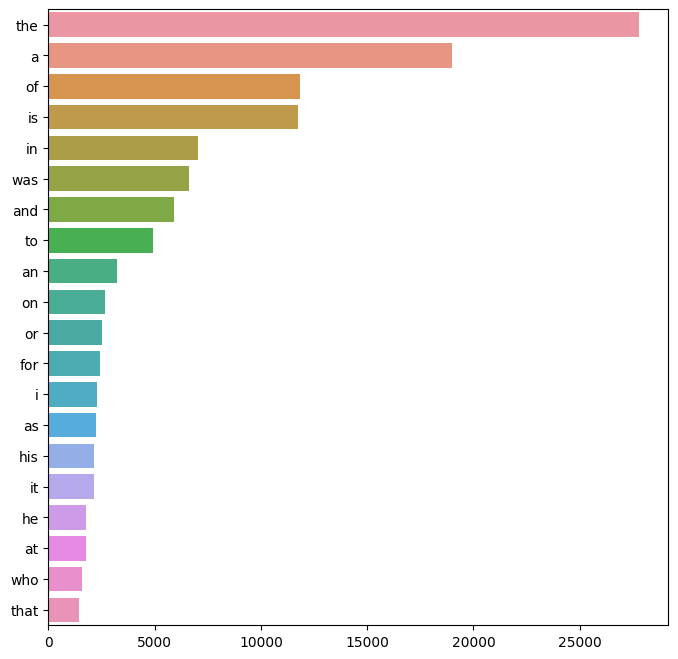

In [50]:
_=plt.figure(figsize=(8,8))
sns.barplot(x=list(dict(Counter(stopwords_dic).most_common(20)).values()),
            y=list(dict(Counter(stopwords_dic).most_common(20)).keys())
            );

#### The above barplot explains that the is most used stopword in story.

### Let's see most used words other than stopwrods.

In [51]:
non_stp_words=defaultdict(int)
for word in words:
    if word not in stopwords:
        non_stp_words[word]+=1

In [52]:
list(dict(Counter(non_stp_words).most_common(20)).items())

[('...', 66640),
 ('(', 27086),
 (')', 23114),
 ('chapter', 20100),
 (',', 19548),
 ('--', 18172),
 ('cnn', 17652),
 ('.', 15453),
 ("''", 5201),
 ('\\n\\nthe', 4300),
 ("'s", 4042),
 (';', 3495),
 ('\\n\\n', 3313),
 ('``', 2829),
 (':', 2648),
 ('new', 1966),
 ('\\n\\na', 1677),
 ('one', 1516),
 ('officially', 1205),
 ('city', 1199)]

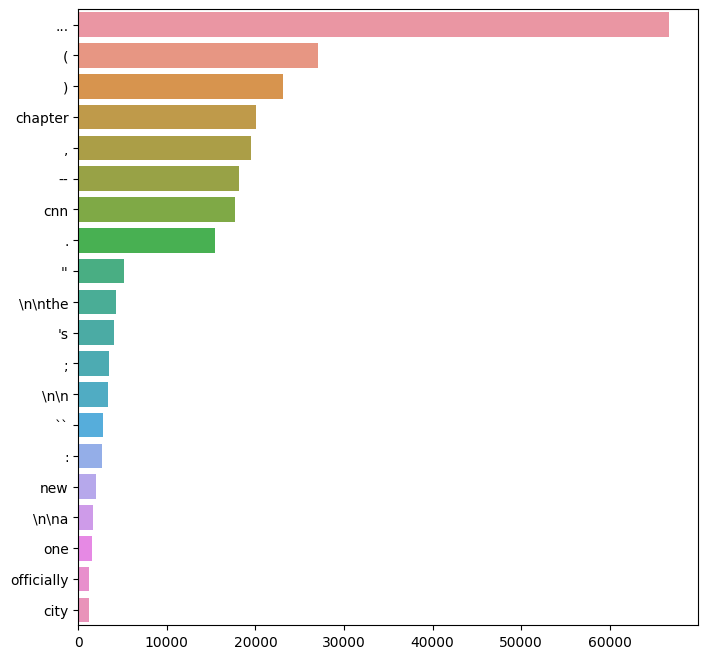

In [53]:
_=plt.figure(figsize=(8,8))
sns.barplot(x=list(dict(Counter(non_stp_words).most_common(20)).values()),
            y=list(dict(Counter(non_stp_words).most_common(20)).keys())
            );

### The above barplot explains that ...(ellipsis) is most used in the story.
### Note:The result based on raw text

### Let's see top Bi-gram in story.

In [54]:
def top_ngram(txt=None,n=0):
    n_gram=(pd.Series(nltk.ngrams(txt, n)).value_counts().sort_values(ascending=False))[:10]
    return n_gram, sns.barplot(x=n_gram.values,
                        y=n_gram.index);

(((, cnn)      17523
 (cnn, ))      17523
 (), --)       16829
 (is, a)        4798
 (\n\n, '')     2720
 (), is)        2701
 (is, the)      2539
 (--, the)      2234
 (--, a)        2228
 (in, the)      2189
 Name: count, dtype: int64,
 <Axes: >)

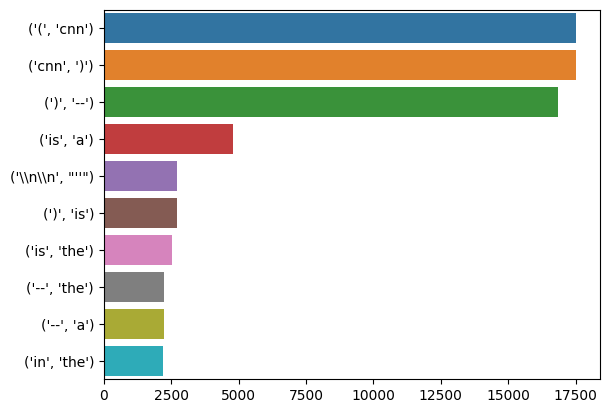

In [55]:
top_ngram(words,2)

#### The above chart explains that (, cnn) is most used bi-gram in story.

### Let's see top Tri-gram in story.

(((, cnn, ))             17523
 (cnn, ), --)            16321
 (), --, a)               2108
 (), --, the)             2012
 (), is, a)               1225
 (,, officially, the)      849
 (), is, the)              773
 (washington, (, cnn)      687
 (new, york, ()            664
 (york, (, cnn)            664
 Name: count, dtype: int64,
 <Axes: >)

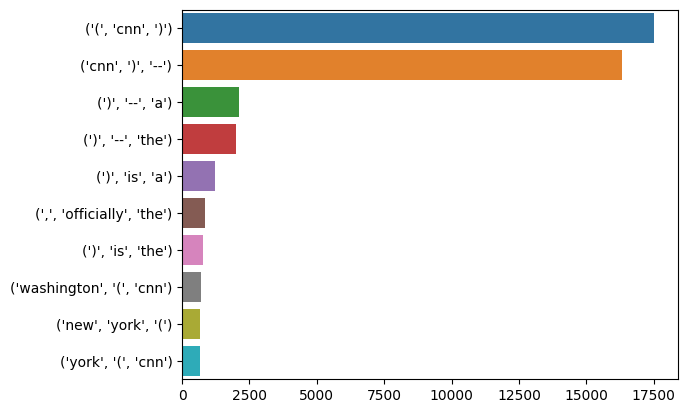

In [56]:
top_ngram(words,3)

#### The above chart explains that (, cnn, ) is most used tri-gram in story.

### Tokenize the story and then use the English pipeline to extract the named entity information.

In [57]:
nlp = spacy.load("en_core_web_sm")
vocab_words = set(nlp.vocab.strings)
nlp.max_length=101629960

In [58]:
unique_story=train['Story'].unique()

In [59]:
doc=nlp(" ".join([j for i in unique_story for j in i.split()]))

### Store entities and text in dataframe.

In [60]:
all_ent=[(x.text,x.label_) for x in doc.ents]

In [61]:
cat_ents=pd.DataFrame()
cat_ents['cat_ent']=[j for i ,j in all_ent]
cat_ents['txt']=[i for i ,j in all_ent]

### Let's see top named entity information category.

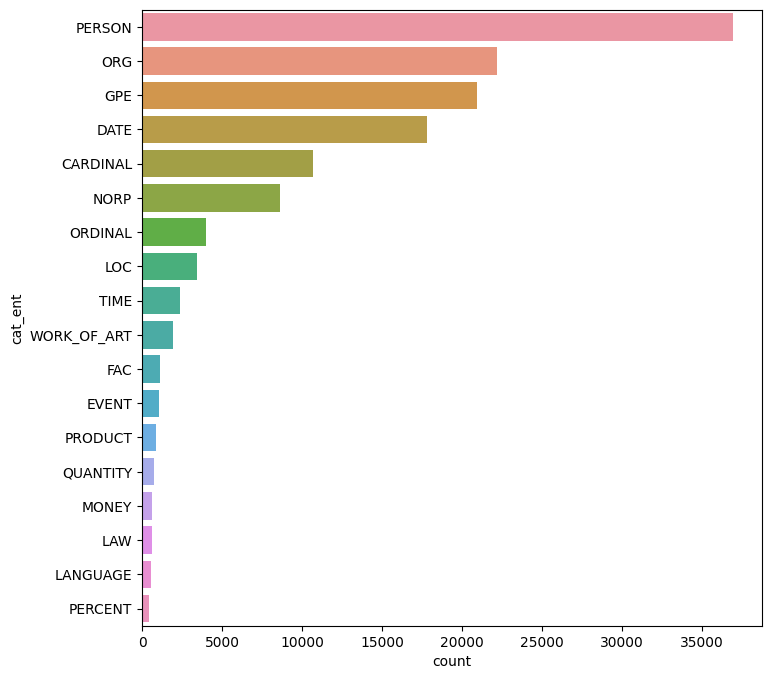

In [62]:
plt.figure(figsize=(8,8))
sns.countplot(y=cat_ents['cat_ent'],order=cat_ents['cat_ent'].value_counts().index);

#### The above inforamtion shows that person, org, gpe are the top named enity information category.

### Let's see what are the tokens classified under top 10 named entity category.

In [63]:
clr=[]
for name, hex in matplotlib.colors.cnames.items():
    if 'dark' in name:
        clr.append(name)

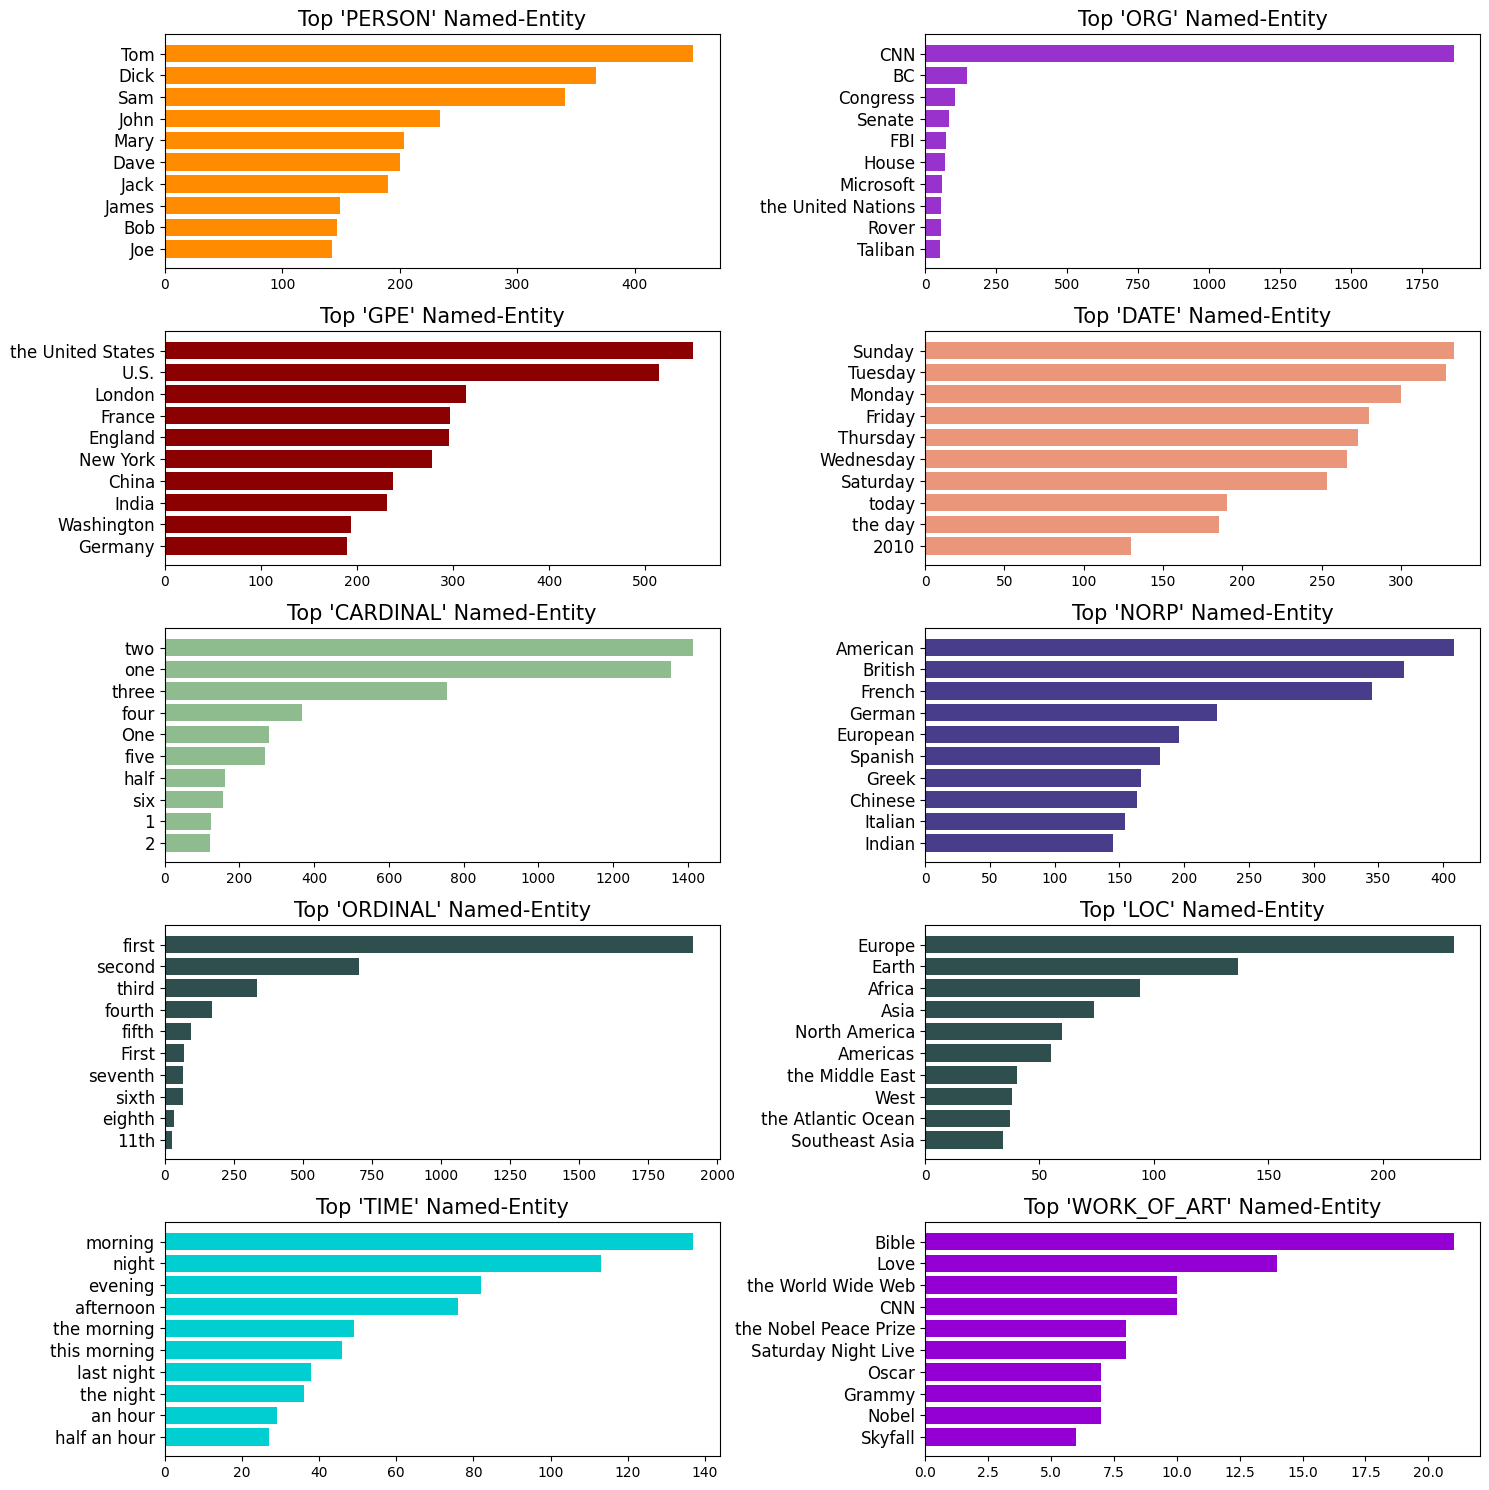

In [64]:
fig=plt.subplots(figsize=(15, 15))
for i,(col,clrs)  in enumerate(zip(cat_ents['cat_ent'].value_counts().nlargest(10).index.values
                                   ,clr[9:19])):    
    _=plt.subplot(5,2,i+1)
    df=(cat_ents[cat_ents['cat_ent']==col].groupby(['txt'])['txt'].agg({'count'}).
    reset_index().sort_values('count',ascending=False)[:10])
    df=df.sort_values('count')
    _=plt.barh(df['txt'],df['count'],color=clrs)
    _=plt.title(f"Top '{col}' Named-Entity",fontsize=15)
    _=plt.ylabel("")
    _=plt.yticks(fontsize=12)
    _=plt.tight_layout()  
plt.show()

### Let's classify the words into parts of speech.

#### Let's use nltk pos_tagger function and classify the words.

In [65]:
pos_doc=nltk.pos_tag(word_tokenize(" ".join([j for i in unique_story for j in i.split()])))

In [66]:
pos_tag=pd.DataFrame()
pos_tag['tag']=[j for i ,j in pos_doc]
pos_tag['txt']=[i for i ,j in pos_doc]

### Let's see top used POS tag.

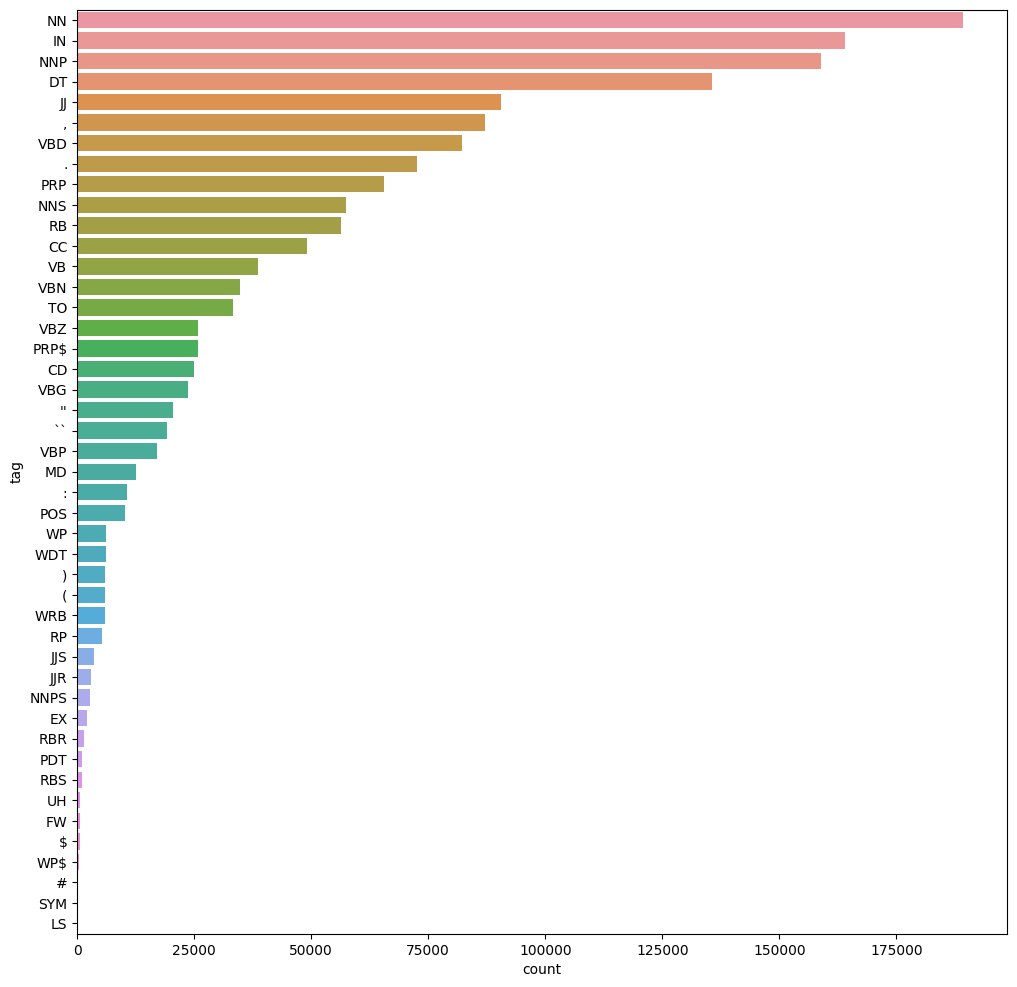

In [67]:
plt.figure(figsize=(12,12))
sns.countplot(y=pos_tag['tag'],order=pos_tag['tag'].value_counts().index);

#### The above chart shows that most words in the story are tagged under noun(common), prepositions or conjunctions, proper noun.

### Let's see what are the words classified under the top pos tag category.

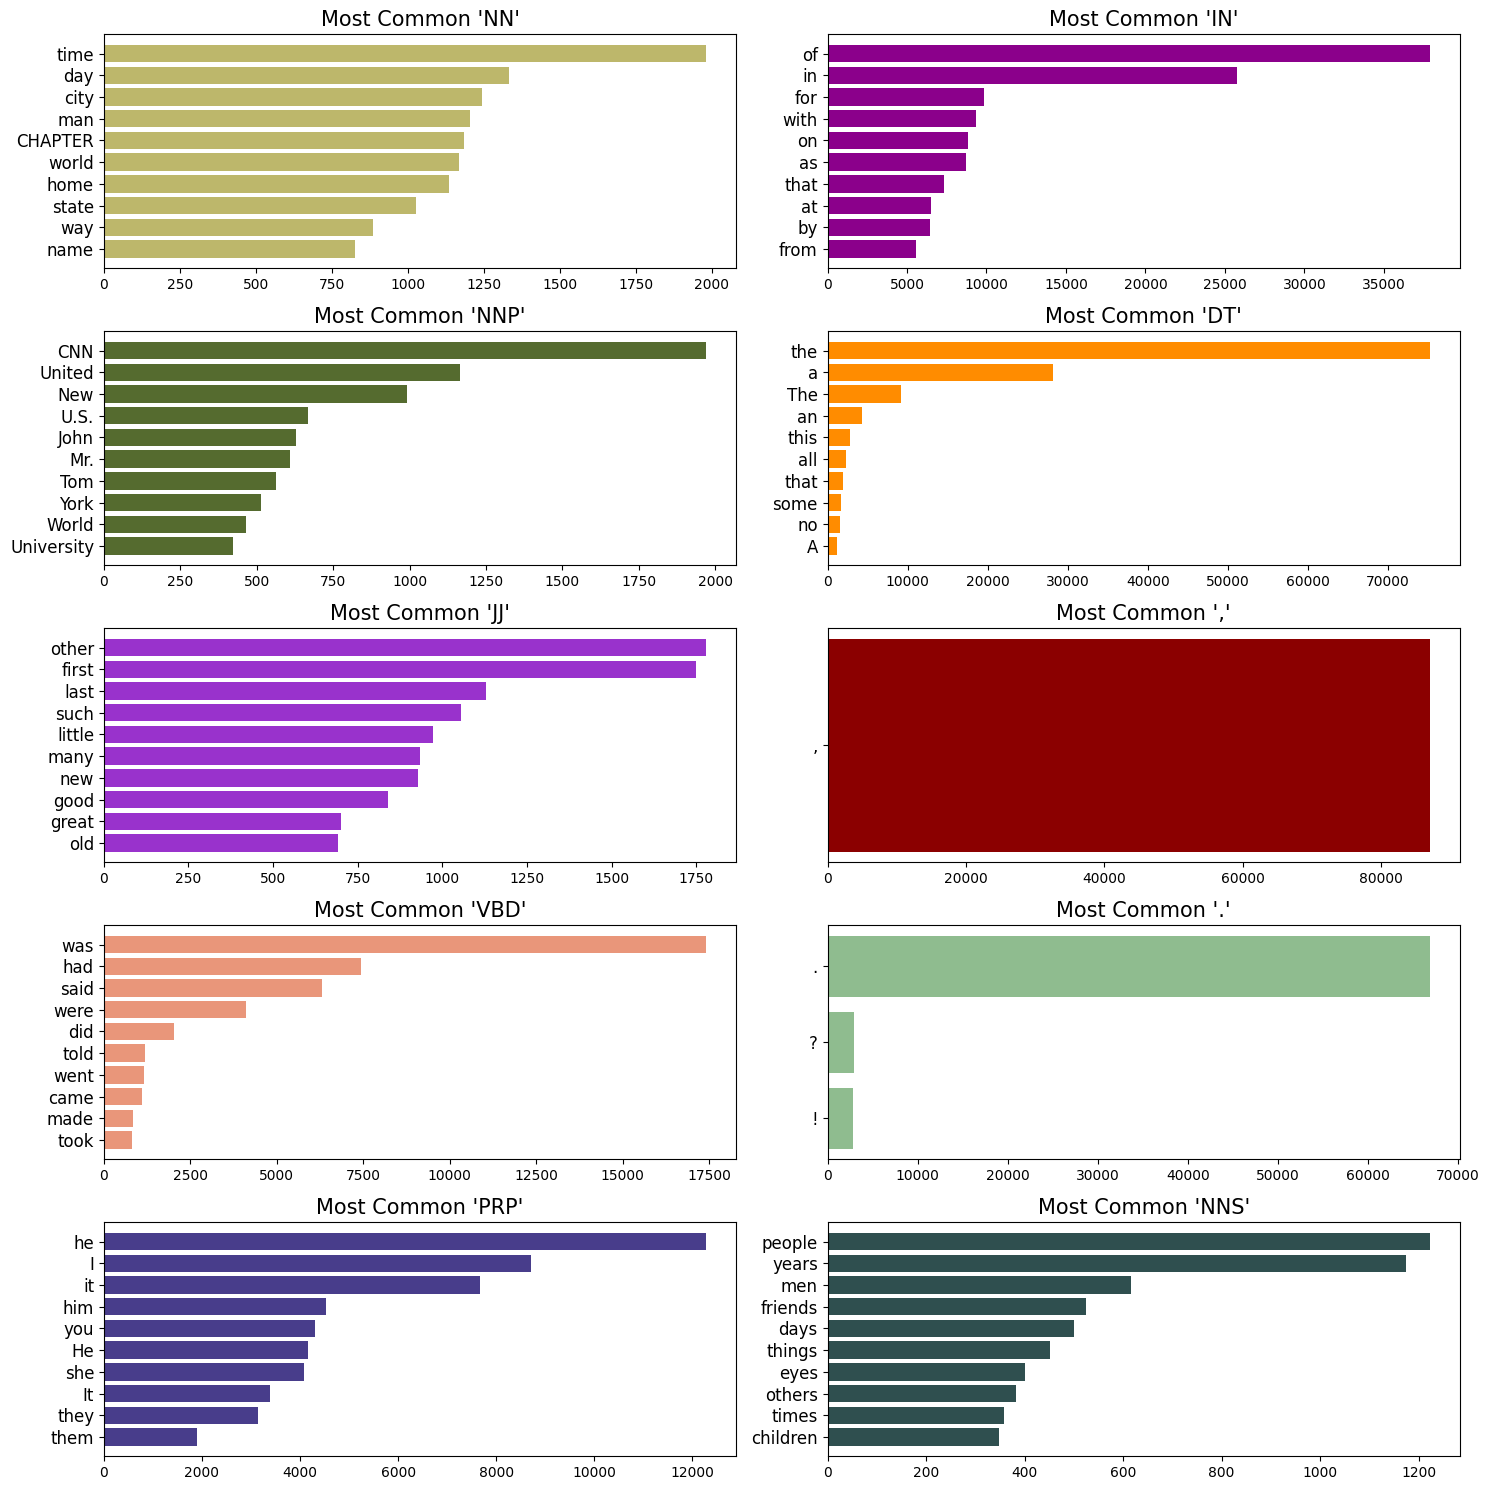

In [68]:
fig=plt.subplots(figsize=(15, 15))
for i,(col,clrs)  in enumerate(zip(pos_tag['tag'].value_counts().nlargest(10).index.values
                                   ,clr[6:16])):
    _=plt.subplot(5,2,i+1)
    df=(pos_tag[pos_tag['tag']==col].groupby(['txt'])['txt'].agg({'count'}).
    reset_index().sort_values('count',ascending=False)[:10])
    df=df.sort_values('count')
    _=plt.barh(df['txt'],df['count'],color=clrs)
    _=plt.title(f"Most Common '{col}'",fontsize=15)
    _=plt.ylabel("")
    _=plt.yticks(fontsize=12)
    _=plt.tight_layout()  
plt.show()

### Most used mixed (Formal,Informal) Contractions.

In [69]:
def mixed_contraction(text):
    res=text.str.lower().str.extract("([a-zA-Z]+'[a-zA-Z]+)")
    return res.dropna().value_counts().nlargest(10), res.dropna().value_counts().nlargest(10).sort_values(ascending=True).plot(kind='barh',figsize=(15,10))

(it's         1908
 don't        1748
 world's      1453
 didn't       1450
 i'm           946
 can't         736
 country's     685
 he's          674
 that's        632
 wasn't        601
 Name: count, dtype: int64,
 <Axes: ylabel='0'>)

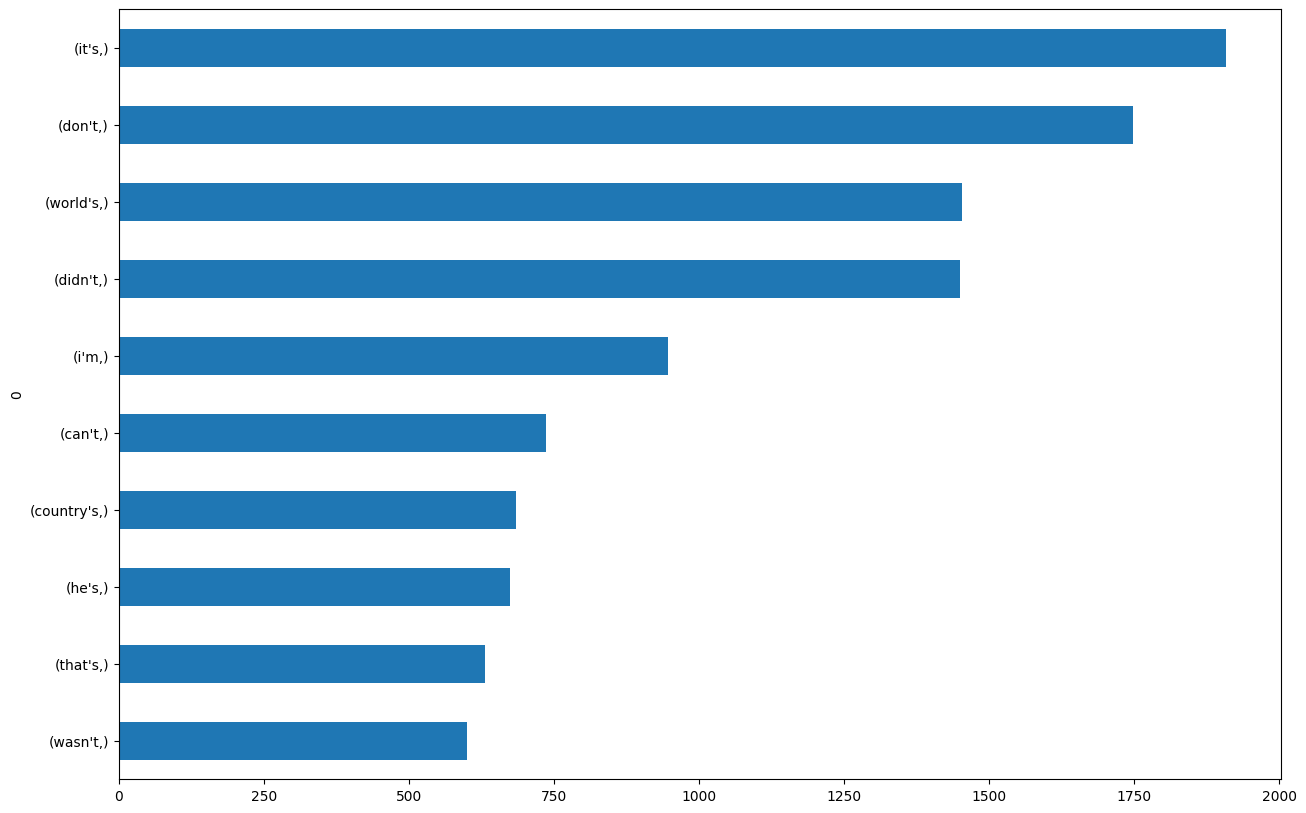

In [70]:
mixed_contraction(train['Story'])

### Let's see is there any diacritics in story.

In [71]:
def non_ascii(text):
    res=text.str.lower().str.extract("([^\x00-\x7F]+)")
    return res.dropna().value_counts().nlargest(20), res.dropna().value_counts().nlargest(10).sort_values(ascending=True).plot(kind='barh',figsize=(15,10))

(–     2908
 —     1453
       1423
 é     1114
 »      835
 ˈ      333
 ü      308
 ’      296
 ó      265
 £      265
 æ      242
 á      234
 ā      227
 ö      204
 ñ      193
 è      182
 °      163
 í      158
  –     141
 ç      130
 Name: count, dtype: int64,
 <Axes: ylabel='0'>)

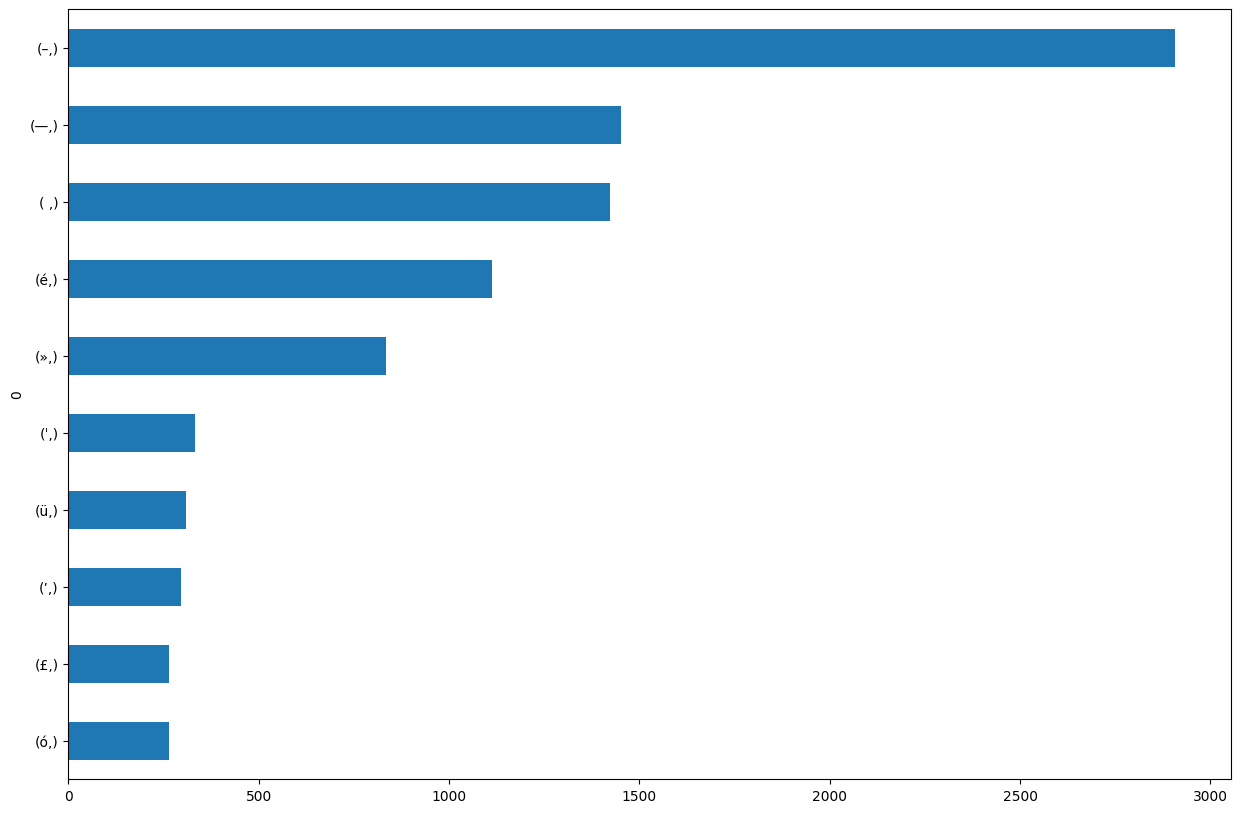

In [72]:
non_ascii(train['Story'])

### Let's see is there any currency symbol in story.

In [73]:
def currency(text):
    res=text.str.lower().str.extract("([$¢£¤¥֏؋৲৳৻૱௹฿៛\u20a0-\u20bd\ua838\ufdfc\ufe69\uff04\uffe0\uffe1\uffe5\uffe6])")
    return res.dropna().value_counts().nlargest(10), res.dropna().value_counts().nlargest(10).sort_values(ascending=True).plot(kind='barh',figsize=(8,5))

($    3664
 £     390
 €     111
 ₥      66
 ¥      18
 ₤      15
 ₣      12
 Name: count, dtype: int64,
 <Axes: ylabel='0'>)

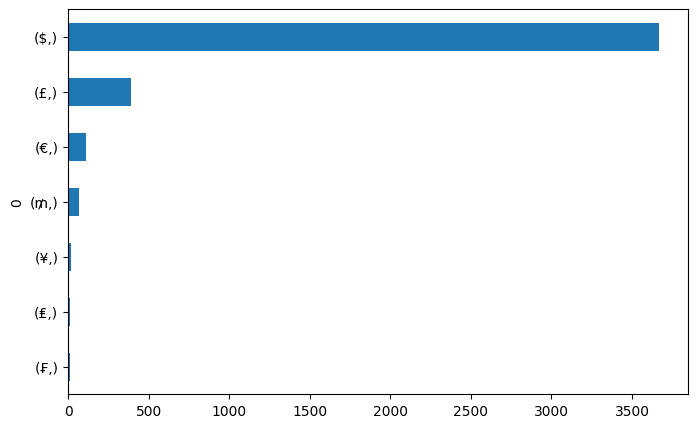

In [74]:
currency(train['Story'])

### Let's find the keywords in story by using TF-IDF.

### Fuction for clean the text.

In [75]:
def pre_process(txt):
    text=re.sub("(\')","",txt)
    text=re.sub("\d+|\W+"," ",text)
    return text

In [76]:
train['clean_story']=train['Story'].apply(lambda x:pre_process(x.lower()))

### Apply TF-IDF to cleaned text.

In [77]:

tfidf_vec=TfidfVectorizer(smooth_idf=True,use_idf=True,stop_words=stopwords,)
tfidf_vec.fit_transform(train['clean_story'].to_list())

<66611x54169 sparse matrix of type '<class 'numpy.float64'>'
	with 7369184 stored elements in Compressed Sparse Row format>

### Extract feature names from tf-idf vector.

In [78]:
feature_names = tfidf_vec.get_feature_names_out()

### Function to get top 3 keywords from the story.

In [79]:
def get_tfidf_term(doc,vectorizer,features,top_n):
    tf_idf_vector = vectorizer.transform([doc])
    coo_matirx=tf_idf_vector.tocoo()
    doc_score=zip(coo_matirx.col,coo_matirx.data)
    sorted_doc_score=sorted(doc_score, key=lambda x: (x[1], x[0]), reverse=True)
    term={}
    for index, frequency in sorted_doc_score[:top_n]:
        term[index]=features[index]
    
    result=", ".join(t for t in term.values())
    return result
    

### Get top 3 keywords.

In [80]:
kw=[]
for t in tqdm_notebook(unique_story):
     kw.append([get_tfidf_term(t,tfidf_vec,feature_names,3)])
    

  0%|          | 0/5065 [00:00<?, ?it/s]

In [81]:
unique_story_df=pd.DataFrame()
unique_story_df['story']=unique_story
unique_story_df['keywords']=[t[0]  for t in kw]

In [82]:
unique_story_df.head()

,story,keywords
0,CHAPTER IV. \n\nNotwithstanding the earnest in...,"delafield, maria, charlotte"
1,"(CNN) -- Polk County, Florida, detectives arre...","manieri, everitt, waveland"
2,"Malawi (, or ; or [maláwi]), officially the Re...","malawi, nyasaland, africa"
3,CHAPTER XXXII. \n\nMR. GILMORE'S SUCCESS. \n\n...,"cockey, loring, mr"
4,"Computer security, also known as cybersecurity...","attacks, network, denial"


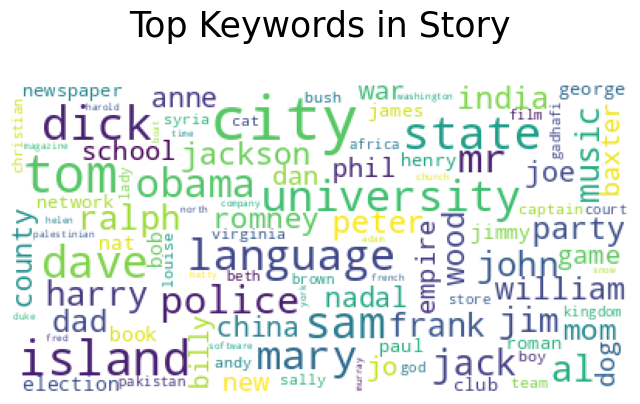

In [83]:
wordcloud(unique_story_df,'keywords',plot_size=(8,8),title="Top Keywords in Story\n")